<a href="https://colab.research.google.com/github/kty3452/ML-Class/blob/main/HumanActivityTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Add, GlobalAveragePooling1D, Embedding
)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


# ===================== 데이터 로드 =====================
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    return np.dstack(loaded)

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/ML_Class/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/ML_Class/')
    trainy, testy = trainy - 1, testy - 1
    trainy_one_hot, testy_one_hot = to_categorical(trainy), to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot


# ===================== 데이터 분할 =====================
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

/tmp/ipython-input-2255217487.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2255217487.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2255217487.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2255217487.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=Tr

(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


In [9]:
# ===================== 수정된 Positional Encoding 함수 =====================
def positional_encoding(length, depth):
    # depth가 홀수여도 문제없이 sin, cos 페어 생성
    depth = int(depth)
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates

    # sin, cos 길이 맞추기
    sines = np.sin(angle_rads)
    coses = np.cos(angle_rads)
    pos_encoding = np.concatenate([sines, coses], axis=-1)

    # feature 수 초과 시 잘라내기
    pos_encoding = pos_encoding[:, :depth]

    return tf.cast(pos_encoding, dtype=tf.float32)


# ===================== Transformer Encoder 블록 =====================
def transformer_encoder(inputs, num_heads=4, ff_dim=128, dropout=0.1):
    # Self-Attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1], activation="relu")(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

In [10]:
# ===================== Simple Transformer 모델 =====================
inputs = Input(shape=(n_timesteps, n_features))

# 위치정보 추가 (Positional Encoding)
pos_encoding = positional_encoding(n_timesteps, n_features)
x = inputs + pos_encoding  # broadcasting

# Transformer Encoder (1~2층)
x = transformer_encoder(x, num_heads=4, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, num_heads=4, ff_dim=128, dropout=0.1)

# Global Pooling + Dense
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(n_outputs, activation='softmax')(x)

simple_transformer = Model(inputs, outputs)
simple_transformer.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

simple_transformer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 9)    │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 9)    │      1,413 │ add_2[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 9)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 9)    │         18 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 128)  │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128, 9)    │      1,161 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 128, 9)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 9)    │         18 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 9)    │      1,413 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 128, 9)    │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 9)    │         18 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128, 128)  │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 128)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128, 9)    │      1,161 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 128, 9)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 9)    │         18 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 9)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 9,834 (38.41 KB)

 Trainable params: 9,834 (38.41 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# ===================== 학습 =====================
history = simple_transformer.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.3659 - loss: 1.4779 - val_accuracy: 0.6587 - val_loss: 0.7950
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6640 - loss: 0.7684 - val_accuracy: 0.7063 - val_loss: 0.5837
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7072 - loss: 0.6303 - val_accuracy: 0.8246 - val_loss: 0.4761
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7897 - loss: 0.5107 - val_accuracy: 0.8817 - val_loss: 0.3644
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8299 - loss: 0.4192 - val_accuracy: 0.8831 - val_loss: 0.3266
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8572 - loss: 0.3703 - val_accuracy: 0.8695 - val_loss: 0.3238
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8789 - loss: 0.3248 - val_accuracy: 0.9082 - val_loss: 0.2492
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8738 - loss: 0.3179 - val_accuracy: 

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Accuracy: 0.836443841194435
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       496
           1       0.74      0.86      0.79       471
           2       0.75      0.81      0.78       420
           3       0.86      0.75      0.80       491
           4       0.82      0.85      0.83       532
           5       1.00      1.00      1.00       537

    accuracy                           0.84      2947
   macro avg       0.84      0.83      0.83      2947
weighted avg       0.84      0.84      0.84      2947



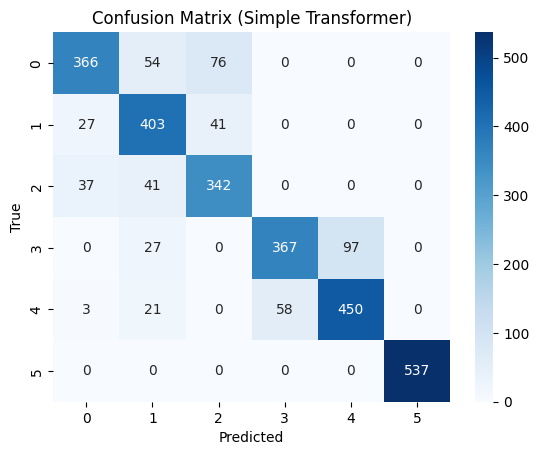

In [12]:
# ===================== 평가 =====================
pred = simple_transformer.predict(testX)
pred = np.argmax(pred, axis=-1)

cm = confusion_matrix(testy, pred)
print("Accuracy:", accuracy_score(testy, pred))
print(classification_report(testy, pred))

sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.title("Confusion Matrix (Simple Transformer)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

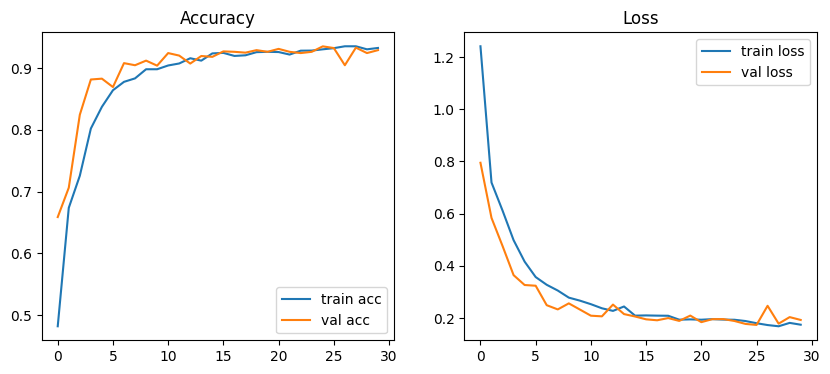

In [13]:

# ===================== 학습 곡선 =====================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
